# 학습 관련된 기술들

### 다룰 주제: 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등 -> 다 중요한 것들

### SGD 복습

W <- W - $\eta{\operatorname{d}\!L\over\operatorname{d}\!W}$

여기서 $\eta$(에타)는 학습률로 0.01이나 0.001임

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr#learning rate
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -=self.lr*grads[key]

### SGD의 단점

SGD는 단순하고 구현도 쉽지만, 때에 따라 비효율적일 때가 있음.

비등방성함수에는 탐색 경로가 지그재그여서 비효율적임.

### 모멘텀

모멘텀은 '운동량'을 뜻하는 단어로 물리와 관계가 있음.

W <- W + v 여기서 v는 velocity

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### Adagrad

신경망에서는 학습률이 작으면 학습시간이 길어지고 너무 크면 발산하여 학습이 제대로 이뤄지지 않아서  
학습률이 중요한데 전체적인 학습률 값을 낮추는 것을 발전시킨 버전이 Adagrad

$ h \longleftarrow h+{\partial L\over\partial W}\bigodot{\partial L \over\partial W} $

$ W \longleftarrow W - \eta{1\over\sqrt{h}}{\partial L\over \partial W}$

h는 기존 기울기 값을 제곱하여 계속 더해주고  
매개변수 갱신할 때는 1/루트h를 곱해 학습률을 조정함.  
매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다는 뜻 -> 학습률 감소가 매개변수의 원소마다 적용됨을 뜻함

AdaGrad는 과거의 기울기를 제곱하여 계속 더하다보니 진행할수록  
갱신강도가 약해져 계속 학습하다보면 어느 순간 갱신량이 0이 됨  
이것을 개선한 기법이 RMSProp임.  
RMSProp은 과거의 모든 기울기를 균일하게 더하지 않고 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영함.  
* 이를 지수이동평균(Exponential Moving Average EMA)라 한다.

In [4]:
class Adagrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr*grads[key]/(np.sqrt(self.h[key])+1e-7)#여기서 1e-7이 0으로 나누는 사태를 막아줌

Adagrad는 u축 방향이 기울기가 커서 크게 움직이지만 큰 움직임에  
비례하여 갱신 정도도 큰 폭으로 작아지도록 조정됨.  
따라서 y축 방향으로 갱신 강도가 빠르게 약해지고 지그재그 움직임이 줄어듬

### Adam

모멘텀과 Adagrad를 합친 것.

## 그래서 어느 갱신 방법을 이용할텨?

-> 문제마다 다름  
내가 배우는 책에서는 SGD와 Adam 주로 사용

## 가중치의 초깃값

신경망 학습에서 특히 중요한 것이 가중치의 초깃값.

### if 초깃값 0

오버피팅을 억제하기 위해 가중치 감소라는 기법을 사용한다.  
하지만 가중치의 초깃값을 0으로 설정하면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문에 안됨

### 은닉층의 활성화값 분포

은닉층의 활성화값(호라성화 함수의 출력 데이터)의 분포를 관찰하면 좋은 정보를 얻을 수 있음

밑은 CS231n 수업에 나온 내용으로 활서오하 함수로 시그모이드 함수를 사용하는 5층  
신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활서오하값 분포를 히스토그램으로 그리는 코드  

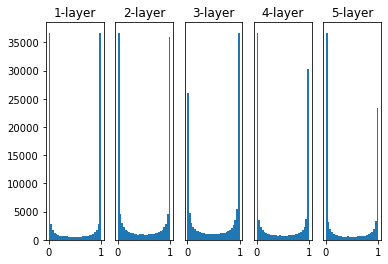

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

0과 1에 분포가 치우쳐 있는 것이 기울기 소실임

In [6]:
# w = np.random.randn(node_num, node_num)*1
w = np.random.randn(node_num, node_num)*0.01

다수의 뉴런이 거의 같은 출력하고 있으니 뉴런을 여러 개 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어진다는 뜻.  
-> 100개의 뉴런이 거의 같은 값을 출력  
-> 표현력 제한

Xavier 초깃값

이건 일반적인 딥레닝 프레임워크들이 표준적으로 이용중임. cs231에 나오는 Caffe에서도 사용

초깃값의 표준편차가 $1\over\sqrt n$이 되도록 설정하는 것.(n은 앞 층의 노드 수)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
node_num = 100
w = np.random.randn(node_num, node_num)/np.sqrt(node_num)

이걸 사용한 그림을 보면 층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 넓게 분포됨이 보임

이 일그러짐은 sigmoid 함수 대신 tanh 함수를 이용하면 개선됨. -> cs231에 나옴

### ReLU를 사용할 때의 가중치 초깃값  
앞선 Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과임.  
sigmoid 함수와 tanh함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있음.  
그래서 Xavier 초깃값이 적당함.  
반면, ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용해야 함.  
이것을 He 초깃값이라 함.  
He 초깃값은 앞 계층의 노드가 n개일 때, 표준편차가 $\sqrt{2\over n}$인 정규분포를 사용함.  
ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 해석 가능.

분포 결과를 보면 He는 모든 층에서 균일하게 분포되어 있는 것을 확인할 수 있음.

결론: 활성화 함수로 ReLU를 사용할 때는 He 초깃값을, sigmoid나 tanh 등의 S자 모양 곡선일 때는 Xavier 초깃값을 쓰는 것이 적당

### MNIST 데이터셋으로 본 가중치 초깃값 비교

===========iteration:0===========
std=0.01:2.3025167964840527
Xavier:2.313382932527773
He:2.369371674387402
===========iteration:100===========
std=0.01:2.302083182521934
Xavier:2.256025269755567
He:1.4150608575131094
===========iteration:200===========
std=0.01:2.3010931158499757
Xavier:2.148347327795559
He:0.7130707958955489
===========iteration:300===========
std=0.01:2.3017939557345852
Xavier:1.899722729442104
He:0.4783566922518412
===========iteration:400===========
std=0.01:2.301128949011052
Xavier:1.398688247049985
He:0.3611405821323278
===========iteration:500===========
std=0.01:2.305308338672387
Xavier:1.0550968990962133
He:0.4079217557353461
===========iteration:600===========
std=0.01:2.3013437265777785
Xavier:0.7605991012796594
He:0.41784369971487856
===========iteration:700===========
std=0.01:2.3029183751696305
Xavier:0.6303137339574185
He:0.3090949045176996
===========iteration:800===========
std=0.01:2.3052827824918563
Xavier:0.4910971101588094
He:0.3052253240316077
==

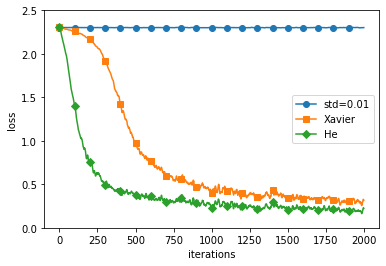

In [4]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


그림에서 보듯 std(표준편차) = 0.01일 때는 학습이 전혀 x임.  
순전파 때 너무 작은 값이 흘렀기 때문. -> 기울기 소실  
He의 경우 아주아주 순조롭게 학습이 진행됨.  
결론: 초깃값은 아중 중요한 포인트임. 간과하기 쉽지만 시작이 중요하니 잘 따져보고 챙기자.

### 배치 정규화

배치 정규화 아이디어: 각 층이 활성화를 적당히 퍼뜨리도록 '강제'하는

배치 정규화가 주목받는 이유  
1. 학습을 빨리 진행할 수 있음.
2. 초깃값에 크게 의존하지 않음.
3. 오버피팅을 억제함(드롭아웃의 필요성 감소)

$\mu_b \longleftarrow$ $1\over m$$\sum_{k=1}^m x_i$

$\sigma_B ^2$ $\longleftarrow$ $(x_i-\mu_B)^2$

$\hat{x_i}$ $\longleftarrow$ $x_i-\mu_B \over sqrt(\mu_B ^2 + \epsilon)$

여기에 미니배치 B = {$x_1, x_2, \ldots, x_m$} 요거 m개의 입력 데이터의 집합에 대해 평균 $\mu_B$와 분산 $\sigma_B ^2$를 구함.  
그리고 입력 데이터를 평균이 0, 분산이 1이 되게 정규화함.  
마지막 엡실론으로 0으로 나누는 사태를 예방  
배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대와 이동 변환을 수행함. 수식으로는 $y_i$$\longleftarrow$$\gamma \hat{x_i} + \beta$

============== 1/16 ==============
epoch:0 | 0.1 - 0.1


C:\Users\phs51\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.119
epoch:2 | 0.097 - 0.13
epoch:3 | 0.097 - 0.142
epoch:4 | 0.097 - 0.157
epoch:5 | 0.097 - 0.164
epoch:6 | 0.097 - 0.181
epoch:7 | 0.097 - 0.212
epoch:8 | 0.097 - 0.233
epoch:9 | 0.097 - 0.251
epoch:10 | 0.097 - 0.26
epoch:11 | 0.097 - 0.273
epoch:12 | 0.097 - 0.281
epoch:13 | 0.097 - 0.305
epoch:14 | 0.097 - 0.316
epoch:15 | 0.097 - 0.325
epoch:16 | 0.097 - 0.347
epoch:17 | 0.097 - 0.364
epoch:18 | 0.097 - 0.377
epoch:19 | 0.097 - 0.38


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 2/16 ==============
epoch:0 | 0.191 - 0.079
epoch:1 | 0.097 - 0.103
epoch:2 | 0.097 - 0.142
epoch:3 | 0.097 - 0.173
epoch:4 | 0.097 - 0.198
epoch:5 | 0.097 - 0.24
epoch:6 | 0.097 - 0.262
epoch:7 | 0.097 - 0.287
epoch:8 | 0.097 - 0.308
epoch:9 | 0.097 - 0.325
epoch:10 | 0.097 - 0.345
epoch:11 | 0.097 - 0.366
epoch:12 | 0.097 - 0.38
epoch:13 | 0.097 - 0.396
epoch:14 | 0.097 - 0.413
epoch:15 | 0.097 - 0.425
epoch:16 | 0.097 - 0.445
epoch:17 | 0.097 - 0.459
epoch:18 | 0.097 - 0.479


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.495
============== 3/16 ==============
epoch:0 | 0.114 - 0.119
epoch:1 | 0.263 - 0.116
epoch:2 | 0.421 - 0.134
epoch:3 | 0.518 - 0.185
epoch:4 | 0.583 - 0.229
epoch:5 | 0.647 - 0.27
epoch:6 | 0.683 - 0.305
epoch:7 | 0.718 - 0.35
epoch:8 | 0.744 - 0.383
epoch:9 | 0.779 - 0.411
epoch:10 | 0.808 - 0.441
epoch:11 | 0.838 - 0.468
epoch:12 | 0.855 - 0.496
epoch:13 | 0.865 - 0.51
epoch:14 | 0.871 - 0.527
epoch:15 | 0.887 - 0.558
epoch:16 | 0.906 - 0.564
epoch:17 | 0.904 - 0.587


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.925 - 0.6
epoch:19 | 0.939 - 0.62
============== 4/16 ==============
epoch:0 | 0.094 - 0.096
epoch:1 | 0.245 - 0.117
epoch:2 | 0.382 - 0.171
epoch:3 | 0.476 - 0.255
epoch:4 | 0.532 - 0.32
epoch:5 | 0.58 - 0.407
epoch:6 | 0.636 - 0.472
epoch:7 | 0.669 - 0.534
epoch:8 | 0.693 - 0.57
epoch:9 | 0.721 - 0.605
epoch:10 | 0.744 - 0.625
epoch:11 | 0.731 - 0.65
epoch:12 | 0.762 - 0.678
epoch:13 | 0.79 - 0.703
epoch:14 | 0.79 - 0.729
epoch:15 | 0.807 - 0.745
epoch:16 | 0.814 - 0.754
epoch:17 | 0.833 - 0.765


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.843 - 0.78
epoch:19 | 0.848 - 0.786
============== 5/16 ==============
epoch:0 | 0.116 - 0.119
epoch:1 | 0.126 - 0.169
epoch:2 | 0.127 - 0.344
epoch:3 | 0.14 - 0.472
epoch:4 | 0.15 - 0.545
epoch:5 | 0.154 - 0.611
epoch:6 | 0.155 - 0.657
epoch:7 | 0.164 - 0.693
epoch:8 | 0.15 - 0.723
epoch:9 | 0.141 - 0.747
epoch:10 | 0.131 - 0.773
epoch:11 | 0.15 - 0.795
epoch:12 | 0.17 - 0.825
epoch:13 | 0.174 - 0.851
epoch:14 | 0.186 - 0.857
epoch:15 | 0.181 - 0.865
epoch:16 | 0.182 - 0.879
epoch:17 | 0.188 - 0.887
epoch:18 | 0.195 - 0.899


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.199 - 0.906
============== 6/16 ==============
epoch:0 | 0.108 - 0.113
epoch:1 | 0.093 - 0.167
epoch:2 | 0.117 - 0.468
epoch:3 | 0.116 - 0.635
epoch:4 | 0.116 - 0.708
epoch:5 | 0.115 - 0.751
epoch:6 | 0.116 - 0.793
epoch:7 | 0.11 - 0.815
epoch:8 | 0.116 - 0.838
epoch:9 | 0.116 - 0.853
epoch:10 | 0.116 - 0.873
epoch:11 | 0.116 - 0.888
epoch:12 | 0.116 - 0.903
epoch:13 | 0.118 - 0.909
epoch:14 | 0.118 - 0.918
epoch:15 | 0.118 - 0.923
epoch:16 | 0.116 - 0.936
epoch:17 | 0.118 - 0.943


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.081 - 0.947
epoch:19 | 0.117 - 0.951
============== 7/16 ==============
epoch:0 | 0.117 - 0.135
epoch:1 | 0.116 - 0.319
epoch:2 | 0.116 - 0.653
epoch:3 | 0.116 - 0.759
epoch:4 | 0.116 - 0.79
epoch:5 | 0.116 - 0.827
epoch:6 | 0.116 - 0.851
epoch:7 | 0.116 - 0.876
epoch:8 | 0.116 - 0.904
epoch:9 | 0.116 - 0.911
epoch:10 | 0.116 - 0.928
epoch:11 | 0.116 - 0.943
epoch:12 | 0.116 - 0.957
epoch:13 | 0.116 - 0.969
epoch:14 | 0.116 - 0.978
epoch:15 | 0.117 - 0.98
epoch:16 | 0.117 - 0.982
epoch:17 | 0.117 - 0.982
epoch:18 | 0.117 - 0.986


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.989
============== 8/16 ==============
epoch:0 | 0.105 - 0.102
epoch:1 | 0.099 - 0.253
epoch:2 | 0.117 - 0.662
epoch:3 | 0.116 - 0.782
epoch:4 | 0.116 - 0.836
epoch:5 | 0.116 - 0.878
epoch:6 | 0.117 - 0.907
epoch:7 | 0.117 - 0.94
epoch:8 | 0.117 - 0.961
epoch:9 | 0.117 - 0.97
epoch:10 | 0.117 - 0.978
epoch:11 | 0.117 - 0.983
epoch:12 | 0.117 - 0.991
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.993
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.998
============== 9/16 ==============
epoch:0 | 0.092 - 0.137
epoch:1 | 0.117 - 0.444
epoch:2 | 0.116 - 0.793
epoch:3 | 0.116 - 0.848
epoch:4 | 0.116 - 0.928
epoch:5 | 0.116 - 0.959
epoch:6 | 0.117 - 0.976
epoch:7 | 0.116 - 0.983
epoch:8 | 0.116 - 0.982
epoch:9 | 0.117 - 0.992
epoch:10 | 0.117 - 0.995
epoch:11 | 0.117 - 0.996
epoch:12 | 0.117 - 0.999
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 1.0
epoch:15 | 0.117 - 1.0
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.117 - 0.129
epoch:1 | 0.116 - 0.738
epoch:2 | 0.117 - 0.832
epoch:3 | 0.117 - 0.877
epoch:4 | 0.117 - 0.911
epoch:5 | 0.117 - 0.923
epoch:6 | 0.117 - 0.974
epoch:7 | 0.117 - 0.949
epoch:8 | 0.117 - 0.985
epoch:9 | 0.116 - 0.993
epoch:10 | 0.117 - 0.994
epoch:11 | 0.117 - 0.995
epoch:12 | 0.117 - 0.998
epoch:13 | 0.117 - 1.0
epoch:14 | 0.117 - 0.873
epoch:15 | 0.117 - 0.994
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 1.0
============== 11/16 ==============
epoch:0 | 0.117 - 0.209
epoch:1 | 0.117 - 0.658
epoch:2 | 0.117 - 0.651
epoch:3 | 0.117 - 0.79
epoch:4 | 0.117 - 0.827
epoch:5 | 0.117 - 0.871
epoch:6 | 0.117 - 0.92
epoch:7 | 0.117 - 0.92
epoch:8 | 0.116 - 0.969
epoch:9 | 0.116 - 0.982
epoch:10 | 0.117 - 0.984
epoch:11 | 0.117 - 0.944
epoch:12 | 0.117 - 0.982
epoch:13 | 0.116 - 0.987
epoch:14 | 0.117 - 0.991
epoch:15 | 0.117 - 0.993
epoch:16 | 0.117 - 0.915
epoch:17 | 0.117 - 0.977
epoch:18 | 0.117 - 0.921


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.996
============== 12/16 ==============
epoch:0 | 0.097 - 0.102
epoch:1 | 0.099 - 0.442
epoch:2 | 0.099 - 0.633
epoch:3 | 0.116 - 0.664
epoch:4 | 0.117 - 0.695
epoch:5 | 0.117 - 0.698
epoch:6 | 0.117 - 0.737
epoch:7 | 0.117 - 0.766
epoch:8 | 0.117 - 0.769
epoch:9 | 0.117 - 0.779
epoch:10 | 0.117 - 0.875
epoch:11 | 0.117 - 0.811
epoch:12 | 0.117 - 0.839
epoch:13 | 0.117 - 0.867
epoch:14 | 0.116 - 0.89
epoch:15 | 0.116 - 0.891
epoch:16 | 0.116 - 0.894
epoch:17 | 0.116 - 0.868
epoch:18 | 0.116 - 0.897


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.904
============== 13/16 ==============
epoch:0 | 0.093 - 0.152
epoch:1 | 0.116 - 0.441
epoch:2 | 0.116 - 0.551
epoch:3 | 0.117 - 0.459
epoch:4 | 0.117 - 0.582
epoch:5 | 0.117 - 0.596
epoch:6 | 0.117 - 0.584
epoch:7 | 0.117 - 0.607
epoch:8 | 0.117 - 0.607
epoch:9 | 0.117 - 0.603
epoch:10 | 0.117 - 0.61
epoch:11 | 0.117 - 0.611
epoch:12 | 0.116 - 0.614
epoch:13 | 0.117 - 0.614
epoch:14 | 0.117 - 0.614
epoch:15 | 0.117 - 0.615
epoch:16 | 0.117 - 0.614
epoch:17 | 0.117 - 0.615
epoch:18 | 0.117 - 0.618


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.693
============== 14/16 ==============
epoch:0 | 0.116 - 0.168
epoch:1 | 0.117 - 0.339
epoch:2 | 0.117 - 0.386
epoch:3 | 0.117 - 0.39
epoch:4 | 0.117 - 0.495
epoch:5 | 0.117 - 0.489
epoch:6 | 0.117 - 0.503
epoch:7 | 0.117 - 0.473
epoch:8 | 0.117 - 0.501
epoch:9 | 0.117 - 0.468
epoch:10 | 0.117 - 0.505
epoch:11 | 0.117 - 0.504
epoch:12 | 0.117 - 0.508
epoch:13 | 0.117 - 0.52
epoch:14 | 0.117 - 0.511
epoch:15 | 0.117 - 0.505
epoch:16 | 0.117 - 0.497
epoch:17 | 0.117 - 0.514
epoch:18 | 0.117 - 0.516


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.514
============== 15/16 ==============
epoch:0 | 0.087 - 0.174
epoch:1 | 0.097 - 0.295
epoch:2 | 0.116 - 0.381
epoch:3 | 0.116 - 0.378
epoch:4 | 0.116 - 0.41
epoch:5 | 0.116 - 0.41
epoch:6 | 0.116 - 0.411
epoch:7 | 0.116 - 0.419
epoch:8 | 0.116 - 0.414
epoch:9 | 0.116 - 0.418
epoch:10 | 0.116 - 0.498
epoch:11 | 0.116 - 0.501
epoch:12 | 0.116 - 0.515
epoch:13 | 0.116 - 0.489
epoch:14 | 0.117 - 0.503
epoch:15 | 0.116 - 0.514
epoch:16 | 0.116 - 0.506
epoch:17 | 0.116 - 0.501
epoch:18 | 0.116 - 0.517


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.524
============== 16/16 ==============
epoch:0 | 0.116 - 0.131
epoch:1 | 0.117 - 0.203
epoch:2 | 0.117 - 0.309
epoch:3 | 0.117 - 0.396
epoch:4 | 0.117 - 0.417
epoch:5 | 0.117 - 0.419
epoch:6 | 0.117 - 0.414
epoch:7 | 0.117 - 0.426
epoch:8 | 0.117 - 0.429
epoch:9 | 0.117 - 0.493
epoch:10 | 0.117 - 0.523
epoch:11 | 0.117 - 0.509
epoch:12 | 0.117 - 0.521
epoch:13 | 0.117 - 0.529
epoch:14 | 0.117 - 0.516
epoch:15 | 0.117 - 0.514
epoch:16 | 0.117 - 0.496
epoch:17 | 0.117 - 0.504
epoch:18 | 0.117 - 0.511
epoch:19 | 0.117 - 0.525


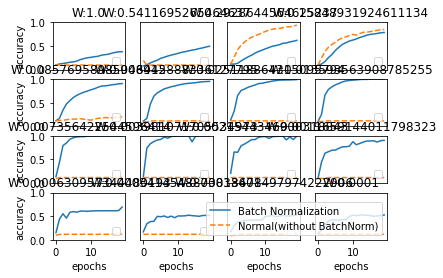

In [6]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


앞에서 언급한 3가지를 다 보여줌.